1. Fix the hight initial loss
   - Add multiplier of `0.01` and `0` to `W2` and `b2` respectively to reduce high initial loss. The random initialization makes weights have high range of values, thus multiplying by small multipliers make loss smaller in the beginning.
   - This also makes model optimize loss better.

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [8]:
BLOCK_SIZE = 3
N_EMBED = 10
N_HIDDEN = 200
N_EPOCHS = 200000
BATCH_SIZE = 32

In [9]:
def createWordsMapping(filename = 'names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

words, stoi, itos, n_vocab = createWordsMapping()

In [10]:
def buildDataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], block_size)
  Xte, Yte = buildDataset(words[n2:], block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)

In [11]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
  g = torch.Generator().manual_seed(2147483647)
  
  C = torch.randn((n_vocab, n_embed), generator=g)
  W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
  b1 = torch.randn(n_hidden, generator=g)
  W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.01
  b2 = torch.randn(n_vocab, generator=g) * 0

  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return parameters

parameters = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 11897


In [12]:
def trainModel(X, Y, parameters, block_size, n_embed, n_epochs, batch_size):
  C, W1, b1, W2, b2 = parameters
  g = torch.Generator().manual_seed(2147483647)
  lossi = []

  for epoch in range(n_epochs):

    # Minibatch Construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

    # Forward Pass
    emb = C[X_batch] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatentae the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # Backward Pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
    for p in parameters:
      p.data += -lr * p.grad
    
    # Track Stats
    lossi.append(loss.log10().item())
    if epoch % 10000 == 0:
      print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  trainedParameters = [C, W1, b1, W2, b2]
  return lossi, trainedParameters

lossi, trainedParameters = trainModel(Xtr, Ytr, parameters, BLOCK_SIZE, N_EMBED, N_EPOCHS, BATCH_SIZE)

      0/ 200000: 3.3179
  10000/ 200000: 2.1848
  20000/ 200000: 2.3320
  30000/ 200000: 2.4731
  40000/ 200000: 1.9858
  50000/ 200000: 2.4827
  60000/ 200000: 2.1361
  70000/ 200000: 2.1642
  80000/ 200000: 2.3967
  90000/ 200000: 2.0793
 100000/ 200000: 2.4436
 110000/ 200000: 2.1291
 120000/ 200000: 2.2657
 130000/ 200000: 1.7314
 140000/ 200000: 2.1808
 150000/ 200000: 2.2475
 160000/ 200000: 2.0536
 170000/ 200000: 1.6976
 180000/ 200000: 2.4663
 190000/ 200000: 2.2927


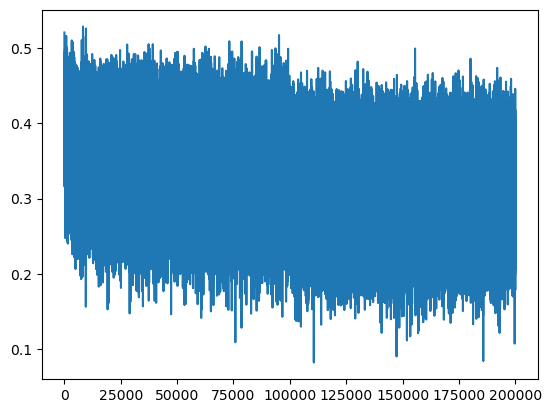

In [13]:
plt.plot(lossi)

In [14]:
@torch.no_grad()
def loss(X, Y, parameters):
  C, W1, b1, W2, b2 = parameters
  emb = C[X]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss

print(f'Train Loss: {loss(Xtr, Ytr, trainedParameters)}')
print(f'Val Loss: {loss(Xdev, Ydev, trainedParameters)}')

Train Loss: 2.068942070007324
Val Loss: 2.129626989364624


In [15]:
def generateExample(parameters, block_size, g, itos):
  C, W1, b1, W2, b2 = parameters
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # (1,block_size, d)
    embcat = emb.view(1, -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  return ''.join(itos[i] for i in out)

def generateExamples(parameters, block_size, itos, numExamples = 20):
  g = torch.Generator().manual_seed(2147483647 + 10)
  examples = []
  for _ in range(numExamples):
    example = generateExample(parameters, block_size, g, itos)
    examples.append(example)
  return examples

generateExamples(trainedParameters, BLOCK_SIZE, itos)

['carman.',
 'amelle.',
 'khi.',
 'mili.',
 'thiyah.',
 'cassie.',
 'rah.',
 'bradheiraciereni.',
 'nellara.',
 'chaihvon.',
 'legy.',
 'dham.',
 'joce.',
 'quinthororeed.',
 'jadiquinterri.',
 'jarynix.',
 'kaellissa.',
 'mel.',
 'edi.',
 'abette.']